In [1]:
import torch
import numpy as np
import pandas as pd
import ast
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [32]:
# Load dataset
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')

In [33]:
train_mod = train.copy()
test_mod = test.copy()

#### This notebook takes the same approach as BERT numerical, except it will only use text and keyword as the predictors


#### Concatenate Text + Keyword feature

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [34]:
tokenizer_distil = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [35]:
train_mod.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [36]:
train_mod.drop(["id", "location"], axis=1, inplace=True)
test_mod.drop(["id","location"], axis=1, inplace=True)

In [37]:
train_mod.columns

Index(['keyword', 'text', 'target'], dtype='object')

In [38]:
test_mod.columns

Index(['keyword', 'text'], dtype='object')

In [47]:
train_mod["keyword_text"] = train_mod["keyword"].astype(str) + " : " + train_mod["text"].astype(str)
test_mod["keyword_text"] = test_mod["keyword"].astype(str) + " : " + test_mod["text"].astype(str)

In [48]:
train_mod["keyword_text"].head()

0    nan : Our Deeds are the Reason of this #earthq...
1         nan : Forest fire near La Ronge Sask. Canada
2    nan : All residents asked to 'shelter in place...
3    nan : 13,000 people receive #wildfires evacuat...
4    nan : Just got sent this photo from Ruby #Alas...
Name: keyword_text, dtype: object

In [49]:
def max_length(text_column, tokenizer):
    max_len = 0
    for text in text_column:
        tokens = tokenizer.tokenize(text)
        # print(tokens)
        max_len = max(max_len, len(tokens))
    print("Max length: ", max_len, " tokens")
    return max_len

In [50]:
max_length(train_mod['keyword_text'], tokenizer_distil)
max_length(test_mod['keyword_text'], tokenizer_distil)

Max length:  107  tokens
Max length:  101  tokens


101

#### Encode keyword_text feature

In [51]:
encoded_inputs =  tokenizer_distil(train_mod['keyword_text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')


In [52]:
encoded_inputs_test = tokenizer_distil(test_mod['keyword_text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

In [53]:
encoded_inputs_test.keys()

dict_keys(['input_ids', 'attention_mask'])

In [54]:
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

In [55]:
input_ids_test = encoded_inputs_test['input_ids']
attention_mask_test = encoded_inputs_test['attention_mask']

In [56]:
print(input_ids)
print(input_ids.shape)
print(attention_mask)
print(attention_mask.shape)

tensor([[ 101, 9468, 1179,  ...,    0,    0,    0],
        [ 101, 9468, 1179,  ...,    0,    0,    0],
        [ 101, 9468, 1179,  ...,    0,    0,    0],
        ...,
        [ 101, 9468, 1179,  ...,    0,    0,    0],
        [ 101, 9468, 1179,  ...,    0,    0,    0],
        [ 101, 9468, 1179,  ...,    0,    0,    0]])
torch.Size([7613, 109])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([7613, 109])


In [57]:
print(input_ids_test)
print(input_ids_test.shape)
print(attention_mask_test)
print(attention_mask_test.shape)

tensor([[ 101, 9468, 1179,  ...,    0,    0,    0],
        [ 101, 9468, 1179,  ...,    0,    0,    0],
        [ 101, 9468, 1179,  ...,    0,    0,    0],
        ...,
        [ 101, 9468, 1179,  ...,    0,    0,    0],
        [ 101, 9468, 1179,  ...,    0,    0,    0],
        [ 101, 9468, 1179,  ...,    0,    0,    0]])
torch.Size([3263, 103])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([3263, 103])


#### Getting the hidden states from BERT

In [62]:
import torch
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
dataset = TensorDataset(input_ids, attention_mask)
dataloader = DataLoader(dataset, batch_size=batch_size)


In [63]:
dataset_test = TensorDataset(input_ids_test, attention_mask_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

In [64]:
from transformers import BertModel

bert_model = BertModel.from_pretrained('bert-base-cased')
bert_model.eval()

text_embeddings = []

with torch.no_grad():
    for batch_input_ids, batch_attention_masks in dataloader:
        outputs = bert_model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        text_embeddings.append(batch_embeddings)

# Concatenate all batch embeddings into a single tensor
text_embeddings = torch.cat(text_embeddings, dim=0)



Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [65]:
bert_model = BertModel.from_pretrained('bert-base-cased')
bert_model.eval()
text_embeddings_test = []

with torch.no_grad():
    for batch_input_ids, batch_attention_masks in dataloader_test:
        outputs = bert_model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        text_embeddings_test.append(batch_embeddings)


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [66]:
# Concatenate all text embeddings into a single tensor
text_embeddings_test = torch.cat(text_embeddings_test, dim=0)

#### Combined Neural Network class

In [67]:
from torch import nn
from torch.optim import Adam
# Create a simple feed-forward neural network
class CombinedModel(nn.Module):
    def __init__(self, bert_output_size, num_classes):
        super(CombinedModel, self).__init__()
        self.layer = nn.Linear(bert_output_size, num_classes)
        

    def forward(self, x):
        return self.layer(x)





In [68]:
class CombinedModelMoreHLs(nn.Module):
    def __init__(self, bert_output_size, num_classes, hidden_size=128, dropout_rate=0.5):
        super(CombinedModelMoreHLs, self).__init__()
        
        self.layer1 = nn.Linear(bert_output_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.activation1 = nn.ReLU()

        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.activation2 = nn.ReLU()

        # self.layer3 = nn.Linear(hidden_size, hidden_size)
        # self.dropout3 = nn.Dropout(dropout_rate)
        # self.activation3 = nn.ReLU()

        # self.layer4 = nn.Linear(hidden_size, hidden_size)
        # self.dropout4 = nn.Dropout(dropout_rate)
        # self.activation4 = nn.ReLU()

        self.output_layer = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.dropout1(x)
        x = self.activation1(x)

        x = self.layer2(x)
        x = self.dropout2(x)
        x = self.activation2(x)

        x = self.output_layer(x)
        return x

#### Convert to numpy for training

In [69]:
combined_features = text_embeddings.numpy()

In [70]:
combined_features

array([[ 0.32892442,  0.15025589, -0.04229771, ..., -0.09539109,
         0.33707178, -0.0771165 ],
       [ 0.4978387 , -0.09464286, -0.14875565, ..., -0.33409485,
         0.27523714, -0.08497208],
       [ 0.34689283, -0.06763789,  0.05054608, ..., -0.13716711,
         0.14380042,  0.13238403],
       ...,
       [ 0.3271216 ,  0.019212  , -0.1528027 , ..., -0.37157854,
         0.3533336 ,  0.08694075],
       [ 0.3527486 , -0.04584332, -0.05895349, ..., -0.16173437,
         0.10456672,  0.00727771],
       [ 0.36284742,  0.03651037, -0.15011537, ..., -0.24968868,
         0.27652884, -0.0946853 ]], dtype=float32)

In [71]:
combined_features_test = text_embeddings_test.numpy()

In [72]:
labels = train_mod['target']

In [73]:
labels_numpy = labels.to_numpy()

In [74]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


In [75]:
import torch.optim as optim
import torch.nn.functional as F

def train_and_validate(train_dataloader, val_dataloader, len_val_dataset, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', lr=1e-3):
    # Replace with your custom model
    model = CombinedModel(bert_output_size=768, num_classes=1)
    #model = CombinedModelMoreHLs(bert_output_size=768, num_classes=1)
    model.to(device)

    print("Loaded Model to device")
    # Define the loss function and optimizer
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print("Initialized Loss and Optimizer")
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_loss = 0.0
        for batch_features, batch_labels in train_dataloader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(batch_features)
            loss = loss_fn(logits, batch_labels)

            # Backward pass
            loss.backward()

            # Update the model parameters
            optimizer.step()

            total_loss += loss.item()

        # Print the average training loss for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader)}')

        # Validation loop
        model.eval()
        total_val_loss = 0.0
        correct_predictions = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_dataloader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                # Forward pass
                logits = model(batch_features)
                loss = loss_fn(logits, batch_labels)

                # Calculate the number of correct predictions
                predictions = (logits > 0).float()
                correct_predictions += (predictions == batch_labels).sum().item()

                total_val_loss += loss.item()

        # Print the average validation loss and accuracy for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {total_val_loss / len(val_dataloader)}, Validation Accuracy: {correct_predictions / len_val_dataset}')
    return correct_predictions / len_val_dataset

In [76]:
torch.tensor(combined_features[1])

tensor([ 4.9784e-01, -9.4643e-02, -1.4876e-01, -3.2651e-01, -2.5679e-01,
         1.0901e-02,  3.8368e-01, -1.8510e-01,  2.4233e-03, -1.0046e+00,
        -2.6205e-01,  3.5760e-01, -1.3486e-01, -5.9549e-02, -4.7859e-01,
         1.4106e-01,  7.8274e-02,  7.4191e-02, -1.5292e-01,  7.1886e-02,
         3.2405e-02, -2.5858e-01,  5.2096e-01, -1.5664e-01,  1.8251e-01,
        -2.9493e-02,  1.8504e-01,  1.8388e-01, -1.6584e-01,  3.8153e-01,
         4.8130e-02,  2.4051e-01, -3.5508e-02,  7.5156e-02, -2.4599e-01,
         2.3295e-01, -6.4475e-02, -3.4745e-01, -1.7739e-02, -1.7528e-01,
        -4.5558e-01,  3.7616e-02,  5.0113e-01, -1.2846e-01, -6.8228e-02,
        -5.2015e-01,  4.2592e-03,  3.4099e-03, -6.8851e-02,  6.7775e-02,
        -7.1310e-02,  2.2127e-02,  1.4899e-01,  4.4502e-02,  1.3000e-01,
        -8.4716e-02, -1.9111e-01,  2.0896e-01, -3.5849e-01,  8.4778e-02,
         2.6382e-01,  1.1745e-01,  1.9626e-01, -1.4913e-02, -3.8132e-02,
        -8.9403e-02,  5.8963e-02,  1.8179e-01, -2.8

In [77]:
type(combined_features)

numpy.ndarray

In [78]:
type(labels)

pandas.core.series.Series

In [79]:
new_data = torch.tensor(labels_numpy).reshape(-1,1)

In [80]:
new_data.shape

torch.Size([7613, 1])

In [81]:
new_data.type()

'torch.LongTensor'

#### Performed with CombinedModel

In [82]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset))
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.5235948272029872
Epoch 1/10, Validation Loss: 0.4949915506608823, Validation Accuracy: 0.7616546290216678
Epoch 2/10, Training Loss: 0.4663602444208826
Epoch 2/10, Validation Loss: 0.4724088155162272, Validation Accuracy: 0.7826657912015759
Epoch 3/10, Training Loss: 0.4532865074382523
Epoch 3/10, Validation Loss: 0.48406710655121277, Validation Accuracy: 0.7806959947472094
Epoch 4/10, Training Loss: 0.4494010262152185
Epoch 4/10, Validation Loss: 0.4701232896113271, Validation Accuracy: 0.7892317793827971
Epoch 5/10, Training Loss: 0.4434612795632342
Epoch 5/10, Validation Loss: 0.46495557408682336, Validation Accuracy: 0.788575180564675
Epoch 6/10, Training Loss: 0.4423698692966321
Epoch 6/10, Validation Loss: 0.4593232859569694, Validation Accuracy: 0.7912015758371634
Epoch 7/10, Training Loss: 0.43738805623896165
Epoch 7/10, Validation Loss: 0.45935271489214524, Validation Accuracy: 0.790544977019041

#### Performed on CombinedModel but with different epoch sizes

In [84]:
epochs = [10, 20, 30, 40, 50, 60]
average_val_accuracy_dict = {}
for num_epoch in epochs:
    val_accuracies = []
    for train_idx, val_idx in skf.split(combined_features, labels):
        # Create TensorDatasets for the current fold
        train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

        # Create DataLoaders for the current fold
        train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

        # Train and validate your model for the current fold
        # Train and validate your model for the current fold and store the validation accuracy
        val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset), num_epoch)
        val_accuracies.append(val_accuracy)

    # Calculate the average validation accuracy across all folds
    average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    average_val_accuracy_dict[num_epoch] = average_val_accuracy
    print(f'Average Validation Accuracy: {average_val_accuracy}')
    print(f'Number of Epochs: {num_epoch}')


Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.5327771462089433
Epoch 1/10, Validation Loss: 0.48894364796383843, Validation Accuracy: 0.768220617202889
Epoch 2/10, Training Loss: 0.46814415345745763
Epoch 2/10, Validation Loss: 0.5174265862369413, Validation Accuracy: 0.7609980302035456
Epoch 3/10, Training Loss: 0.4556555287848933
Epoch 3/10, Validation Loss: 0.47367207834701885, Validation Accuracy: 0.7839789888378201
Epoch 4/10, Training Loss: 0.4465546379369388
Epoch 4/10, Validation Loss: 0.4635471010005287, Validation Accuracy: 0.7905449770190414
Epoch 5/10, Training Loss: 0.44591972600482893
Epoch 5/10, Validation Loss: 0.4687839932934776, Validation Accuracy: 0.7925147734734077
Epoch 6/10, Training Loss: 0.4388005443484452
Epoch 6/10, Validation Loss: 0.4577082927626465, Validation Accuracy: 0.7951411687458962
Epoch 7/10, Training Loss: 0.43755132584707945
Epoch 7/10, Validation Loss: 0.4569778658878741, Validation Accuracy: 0.79514116874589

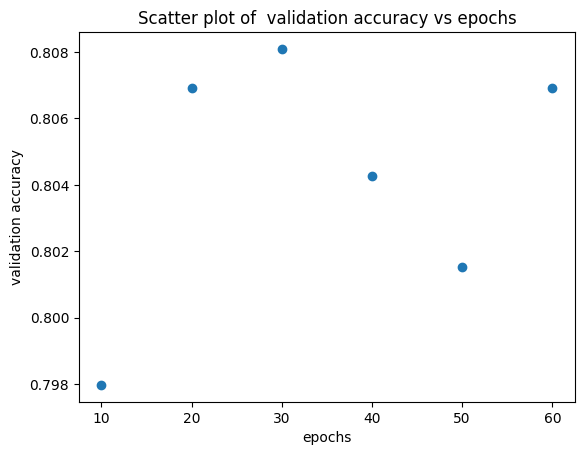

In [86]:
# Using the average_val_accuracy_dict dictionary, plot a graph with number of epochs on x-axis and average validation accuracy on y-axis
import matplotlib.pyplot as plt

# Get the keys and values as separate lists
keys = list(average_val_accuracy_dict.keys())
values = list(average_val_accuracy_dict.values())

# Create a scatter plot
plt.scatter(keys, values)

# Add labels and a title
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.title('Scatter plot of  validation accuracy vs epochs')

# Display the plot
plt.show()


Based on this graph, we can see that epoch = 20 is the optimal parameter as it will give us a higher validation accuracy.

#### Performed with CombinedModelMoreHLs 2 layers

In [83]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset))
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.5274063076755506
Epoch 1/10, Validation Loss: 0.4846456990192074, Validation Accuracy: 0.7721602101116218
Epoch 2/10, Training Loss: 0.46523274522362734
Epoch 2/10, Validation Loss: 0.46970267391017595, Validation Accuracy: 0.7813525935653316
Epoch 3/10, Training Loss: 0.4550515587033406
Epoch 3/10, Validation Loss: 0.4661194227284786, Validation Accuracy: 0.7898883782009193
Epoch 4/10, Training Loss: 0.4464817060123435
Epoch 4/10, Validation Loss: 0.46158494570180386, Validation Accuracy: 0.7879185817465528
Epoch 5/10, Training Loss: 0.4433557475059051
Epoch 5/10, Validation Loss: 0.4603625505538511, Validation Accuracy: 0.7925147734734077
Epoch 6/10, Training Loss: 0.4403670567266271
Epoch 6/10, Validation Loss: 0.4611862741059658, Validation Accuracy: 0.7879185817465528
Epoch 7/10, Training Loss: 0.43609381048619905
Epoch 7/10, Validation Loss: 0.46378067397166295, Validation Accuracy: 0.7866053841103

#### Performed with CombinedModelMoreHLs 3 layers

In [ ]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset))
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.5313310567729586
Epoch 1/10, Validation Loss: 0.43196900028988955, Validation Accuracy: 0.8122127380170716
Epoch 2/10, Training Loss: 0.4674192331046883
Epoch 2/10, Validation Loss: 0.4297476159945052, Validation Accuracy: 0.8102429415627052
Epoch 3/10, Training Loss: 0.4453050988552764
Epoch 3/10, Validation Loss: 0.42063600047252564, Validation Accuracy: 0.8168089297439265
Epoch 4/10, Training Loss: 0.445266618307807
Epoch 4/10, Validation Loss: 0.43529008583199835, Validation Accuracy: 0.8122127380170716
Epoch 5/10, Training Loss: 0.43418479615973987
Epoch 5/10, Validation Loss: 0.4165508486720592, Validation Accuracy: 0.8181221273801708
Epoch 6/10, Training Loss: 0.4391445624312078
Epoch 6/10, Validation Loss: 0.41631536039460393, Validation Accuracy: 0.8154957321076822
Epoch 7/10, Training Loss: 0.4288159793736584
Epoch 7/10, Validation Loss: 0.4162027304358195, Validation Accuracy: 0.81549573210768

#### Performed with CombinedModelMoreHLs 4 layers

In [ ]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset))
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')


Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.5300837656839938
Epoch 1/10, Validation Loss: 0.460299644697243, Validation Accuracy: 0.7826657912015759
Epoch 2/10, Training Loss: 0.4611240529560354
Epoch 2/10, Validation Loss: 0.4158631797821422, Validation Accuracy: 0.8240315167432699
Epoch 3/10, Training Loss: 0.4545359466704014
Epoch 3/10, Validation Loss: 0.4325599910896174, Validation Accuracy: 0.8003939592908733
Epoch 4/10, Training Loss: 0.43679250963521127
Epoch 4/10, Validation Loss: 0.41214321422541794, Validation Accuracy: 0.8200919238345371
Epoch 5/10, Training Loss: 0.440173523608116
Epoch 5/10, Validation Loss: 0.43197188345491105, Validation Accuracy: 0.8076165462902167
Epoch 6/10, Training Loss: 0.4341056599303728
Epoch 6/10, Validation Loss: 0.4266218963561882, Validation Accuracy: 0.824688115561392
Epoch 7/10, Training Loss: 0.4283784716304519
Epoch 7/10, Validation Loss: 0.41462866819575817, Validation Accuracy: 0.8161523309258043


Adding more Hidden layers did not seem to significantly affect the validation accuracy, and is difficult to search for the optimal number of layers because of time constraints. We will use the original CombinedModel for our training.

#### Final Training of CombinedModel with Full Dataset

In [90]:
num_epochs = 30
# Create a TensorDataset for the entire dataset
full_dataset = TensorDataset(torch.tensor(combined_features), torch.tensor(labels_numpy.reshape(-1,1), dtype=torch.float32))

# Create a DataLoader for the entire dataset
full_dataloader = DataLoader(full_dataset, batch_size=8, shuffle=True)

# Train your model on the entire dataset (You can remove the validation loop from your train_and_validate function)
def train_full(train_dataloader, num_epochs=num_epochs, device='cuda' if torch.cuda.is_available() else 'cpu', lr=1e-3):
    # Replace with your custom model
    model = CombinedModel(bert_output_size=768, num_classes=1)
    model.to(device)

    # Define the loss function and optimizer
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_loss = 0.0
        for batch_features, batch_labels in train_dataloader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(batch_features)
            loss = loss_fn(logits, batch_labels)

            # Backward pass
            loss.backward()

            # Update the model parameters
            optimizer.step()

            total_loss += loss.item()

        # Print the average training loss for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader)}')
    return model

# Train the model on the entire dataset
optimized_model = train_full(full_dataloader)


Epoch 1/30, Training Loss: 0.5223386881387785
Epoch 2/30, Training Loss: 0.46496999436723335
Epoch 3/30, Training Loss: 0.45532765047734275
Epoch 4/30, Training Loss: 0.4468674760374452
Epoch 5/30, Training Loss: 0.4439299766428205
Epoch 6/30, Training Loss: 0.4405307971848911
Epoch 7/30, Training Loss: 0.4398189956212745
Epoch 8/30, Training Loss: 0.4363443053272717
Epoch 9/30, Training Loss: 0.43494006550769093
Epoch 10/30, Training Loss: 0.4322102143734443
Epoch 11/30, Training Loss: 0.4336372429911955
Epoch 12/30, Training Loss: 0.42876443394436303
Epoch 13/30, Training Loss: 0.42873296017187235
Epoch 14/30, Training Loss: 0.4287656964225491
Epoch 15/30, Training Loss: 0.42657300426836026
Epoch 16/30, Training Loss: 0.4262735357257624
Epoch 17/30, Training Loss: 0.4247268129828848
Epoch 18/30, Training Loss: 0.42394176583361476
Epoch 19/30, Training Loss: 0.42173309740806075
Epoch 20/30, Training Loss: 0.4218546741587274
Epoch 21/30, Training Loss: 0.42177298578175426
Epoch 22/30, 

Apply on Test Dataset

In [91]:
# Assuming your test data is a numpy array
test_combined_features = combined_features_test
test_combined_features_tensor = torch.tensor(combined_features_test, dtype=torch.float32)
optimized_model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Move the model and test features to the appropriate device
optimized_model.to(device)
test_combined_features_tensor = test_combined_features_tensor.to(device)

# Perform a forward pass through the model to obtain predictions
with torch.no_grad():
    logits = optimized_model(test_combined_features_tensor)

# Process the predictions to get the final predicted targets
# If it's a binary classification problem, you can apply a threshold and convert the output to binary labels (0 or 1)
threshold = 0
predicted_targets = (logits > threshold).float().cpu().numpy()

# If it's a multi-class problem, you can apply a softmax function and get the class with the highest probability
# predicted_targets = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()

print(predicted_targets)


[[1.]
 [0.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]


In [92]:
predicted_targets = predicted_targets.astype(int)
df = pd.DataFrame(predicted_targets, columns=['target'])
df = pd.concat([ test['id'],df], axis=1)

In [229]:
df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [93]:
df.to_csv('test_results/BERT_CombinedNN_text_keyword.csv', index=False)